In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))
adata_betas = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_celltype_betas.h5ad'))

In [5]:
def mcp_dotplot(df, df_size, colorbar_title, size_title, 
                delta=0.1, col_groups=None, vmin=-2.5, vmax=2.5, cmap='Reds', figsize=(8,3)):
    obs = pd.DataFrame(df.index, index = df.index, columns = ['gene_sigs']).astype("category")
    mod_anndata = sc.AnnData(df, obs, dtype=np.float32)
            
    if col_groups == None:
        col_groups = mod_anndata.var_names
                
    ax_dict = sc.pl.dotplot(mod_anndata, show=False, 
                            var_names = col_groups, groupby='gene_sigs',
                            var_group_rotation = 0,
                            dot_size_df = df_size+delta, # small amount added to df_size to make 0's show up
                            dot_color_df = df,
                            colorbar_title = colorbar_title,
                            size_title = size_title,
                            vmin=vmin, vmax=vmax,
                            figsize=figsize,
                            cmap=cmap
                           )
    
    size_legend_ax = ax_dict['size_legend_ax']
    size_legend_ax.clear()
    
    dot_max, dot_min = df_size.values.max(), 0
    largest_dot, smallest_dot = 200, 10
    size_exponent = 1.5
    
    diff = dot_max - dot_min
    step = diff/4
    # a descending range that is afterwards inverted is used
    # to guarantee that dot_max is in the legend.
    size_range = np.arange(dot_max, dot_min-step, step * -1)[::-1]
    if dot_min != 0 or dot_max != 1:
        dot_range = dot_max - dot_min
        size_values = (size_range - dot_min) / dot_range
    else:
        size_values = size_range

    size = size_values**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot

    # plot size bar
    size_legend_ax.scatter(
        np.arange(len(size)) + 0.5,
        np.repeat(0, len(size)),
        s=size,
        color='gray',
        edgecolor='black',
        linewidth=0.2,
        zorder=100,
    )
    size_legend_ax.set_xticks(np.arange(len(size)) + 0.5)
    labels = [
        "{}".format(np.round(x, decimals=1)) for x in size_range
    ]
    size_legend_ax.set_xticklabels(labels, fontsize='small')
    
    ymax = size_legend_ax.get_ylim()[1]
    size_legend_ax.set_ylim(-1.05 - largest_dot * 0.003, 4)
    size_legend_ax.set_title(size_title, y=ymax + 0.45, size='small')

    xmin, xmax = size_legend_ax.get_xlim()
    size_legend_ax.set_xlim(xmin - 0.15, xmax + 0.5)
    
    plt.subplots_adjust(bottom=0.27, top=0.82)
    
    return ax_dict

In [6]:
t_ordered = ['0d', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '6m', '1yr', '2yr']
t_limited = ['12w', '6m', '1yr', '2yr']

def mean_betas_timecourse(mroi, region, cell_gene_pairs, age_groups=None):
    if age_groups is None:
        age_groups = t_ordered
        
    adata_mroi = adata_betas[adata_betas.obs.annotation==mroi]
    
    df_mean = pd.DataFrame(index=age_groups, columns=['_'.join(cp) for cp in cell_gene_pairs],
                           dtype=np.float64)
    
    for age in age_groups:
        adata_age = adata_mroi[adata_mroi.obs.condition == '%s BL6WT.%s' % (age, region)]
        adata_age.obs.index = adata_age.obs.celltype
        
        for ct, g in cell_gene_pairs:
            df_mean.loc[age, '_'.join((ct, g))] = adata_age[ct, g].X[0,0]
    
    df_mean_scaled = df_mean - df_mean.min(axis=0)
    df_mean_scaled = df_mean_scaled / df_mean_scaled.max(axis=0)
    
    # Change in beta (Delta) relative to 12w -- helps show changes in expression when scales vary
    df_delta = df_mean.copy()
    for i in range(len(df_delta)):
        df_delta.iloc[i,:] = df_mean.iloc[i,:]-df_mean.loc['12w',:]
    
    return df_delta, df_mean_scaled

In [7]:
plot_dir = 'fig4_v2'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorica

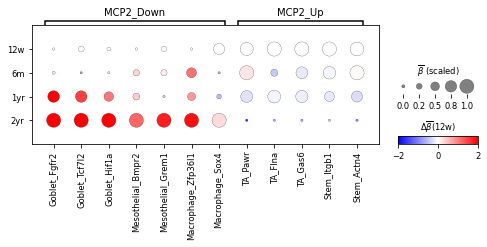

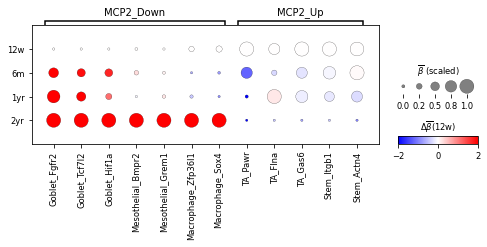

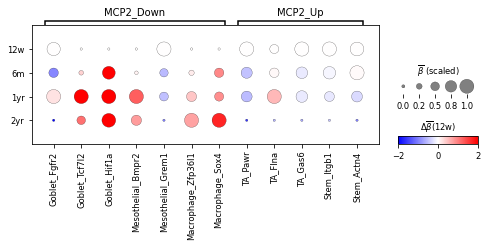

In [11]:
mroi = 'sub-crypt'
mcp_genes = {
    'MCP2_Down': [('Goblet', 'Fgfr2'), 
                ('Goblet', 'Tcf7l2'),
                ('Goblet', 'Hif1a'),
                ('Mesothelial', 'Bmpr2'),
                ('Mesothelial', 'Grem1'),
                ('Macrophage', 'Zfp36l1'), 
                ('Macrophage', 'Sox4'), 
                ],
    'MCP2_Up': [('TA', 'Pawr'),
                ('TA', 'Flna'),
                ('TA', 'Gas6'),
                ('Stem', 'Itgb1'),
                ('Stem', 'Actn4')]
}
col_labels = dict([(k, ['_'.join(cg) for cg in mcp_genes[k]]) for k in mcp_genes.keys()])

for region in ['Proximal', 'Middle', 'Distal']:
    df_delta, df_mean_scaled = mean_betas_timecourse(mroi, 
                                                     region,
                                                     mcp_genes['MCP2_Down']+mcp_genes['MCP2_Up'],
                                                     t_limited)

    ax_dict = mcp_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(12w)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           col_groups=col_labels,
                           vmin=-2, vmax=2, cmap='bwr')
    
    plt.savefig(os.path.join(plot_dir, 'fig4_mcpgenes_%s_%s.svg' % (mroi, region)))

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorica

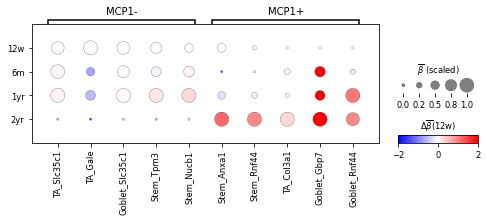

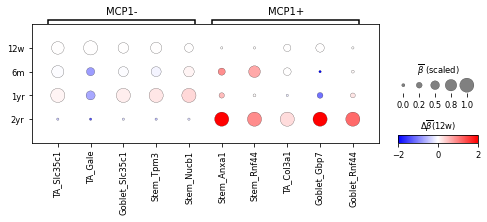

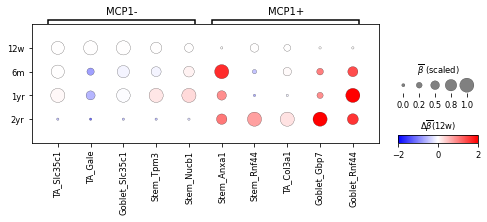

In [7]:
mroi = 'crypt base'

mcp_genes = {
    'MCP1-': [('TA', 'Slc35c1'),
              ('TA', 'Gale'),
              ('Goblet', 'Slc35c1'),
              ('Stem', 'Tpm3'),
              ('Stem', 'Nucb1')],
    'MCP1+': [('Stem', 'Anxa1'),
              ('Stem', 'Rnf44'),
              ('TA', 'Col3a1'),
              ('Goblet', 'Gbp7'),
              ('Goblet', 'Rnf44')]
}
'''
mcp_genes = {
    'MCP1-': [('TA', 'Slc35c1'), ('TA', 'Xist'), ('TA', 'Rplp2'), ('TA', 'Yipf1'), 
              ('TA', 'Gale'), ('TA', 'Fkbp4'), ('TA', 'Ndufs7'), ('TA', 'Raly'), 
              ('TA', 'Ap1s1'), ('TA', 'Phb2'), ('TA', 'Pkm'), ('TA', 'Prkcsh'), 
              ('TA', 'Akr1a1'), ('TA', 'Acads'), ('TA', 'Ndufa10'), ('TA', 'St3gal6'), 
              ('TA', 'Hoxb13'), ('Stem', 'Ly6e'), ('TA', 'Eef1g'), ('TA', 'Acss2'), 
              ('TA', 'Rad23b'), ('TA', 'Msmo1'), ('Stem', 'Nucb1'), ('Goblet', 'Mrpl12'), 
              ('Goblet', 'Bag1'), ('Stem', 'Prdx3'), ('Goblet', 'Nupr1'), ('Stem', 'Tpm3'), 
              ('Stem', 'Manf'), ('Goblet', 'Slc35c1'), ('Stem', 'Tm2d2'), ('Goblet', 'Eif4g1'), 
              ('Stem', 'Cenpb'), ('Goblet', 'Bspry'), ('Stem', 'Copz1'), ('Stem', '2310039H08Rik'), 
              ('Stem', 'Mvp'), ('Stem', 'Kcnq1'), ('Stem', 'Sdc1'), ('Goblet', 'Ssr2')],
    'MCP1+': [('TA', 'Fabp2'), ('TA', 'Hist1h1c'), ('TA', 'Sult1d1'), ('TA', 'Col3a1'), 
              ('TA', 'Hpgd'), ('TA', 'Oat'), ('TA', 'Rnf128'), ('TA', 'mt-Tm'), ('TA', 'Ssr3'), 
              ('TA', 'Sppl2a'), ('TA', 'mt-Co3'), ('TA', 'Golph3'), ('TA', 'Uqcrc2'), 
              ('TA', 'Igfbp7'), ('TA', 'Tm4sf20'), ('Stem', 'Tmco1'), ('Stem', 'Wls'), 
              ('Stem', 'Fut9'), ('Stem', 'Lrig1'), ('Stem', 'Anxa1'), ('Goblet', 'Ell2'), 
              ('Stem', 'Ptprk'), ('Goblet', 'Atpaf1'), ('Stem', 'Actr2'), ('Stem', 'Sh3bgrl'), 
              ('Goblet', 'Chmp3'), ('TA', 'Uap1'), ('Goblet', 'Atxn1'), ('Goblet', 'Chchd3'), 
              ('Stem', 'St13'), ('TA', 'Sec62'), ('Goblet', 'Plgrkt'), ('Goblet', 'Ipmk'), 
              ('Goblet', 'Proc'), ('TA', 'Vdr'), ('Goblet', 'Mapk1ip1'), ('Goblet', 'Gbp7'), 
              ('Stem', 'Hsp90b1'), ('Goblet', 'Plekhg1'), ('Goblet', 'Srgap1'), ('Goblet', 'Cyp2s1'), 
              ('Stem', 'Dlg4'), ('Goblet', 'Wdfy3'), ('Stem', 'Sep15'), ('Goblet', 'Dip2b'), 
              ('Stem', 'Wnk1'), ('Stem', 'Rp2'), ('Goblet', 'Lgalsl'), ('Goblet', 'Usp22'), 
              ('Stem', 'Rnf44'), ('Goblet', 'Stk10')]
}
'''
col_labels = dict([(k, ['_'.join(cg) for cg in mcp_genes[k]]) for k in mcp_genes.keys()])

for region in ['Proximal', 'Middle', 'Distal']:
    df_delta, df_mean_scaled = mean_betas_timecourse(mroi, 
                                                     region,
                                                     mcp_genes['MCP1-']+mcp_genes['MCP1+'],
                                                     t_limited)

    ax_dict = mcp_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(12w)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           col_groups=col_labels,
                           vmin=-2, vmax=2, cmap='bwr',
                          figsize=(8,3)
                         )
    
    plt.savefig(os.path.join(plot_dir, 'fig4_mcpgenes_%s_%s.svg' % (mroi.replace(' ', '-'), region)))

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorica

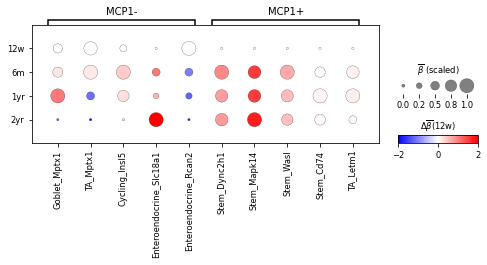

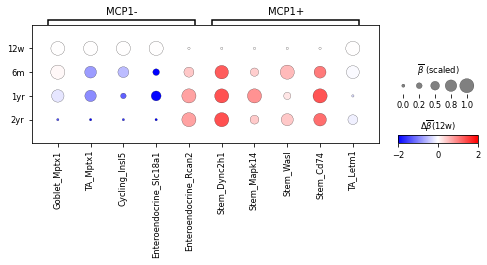

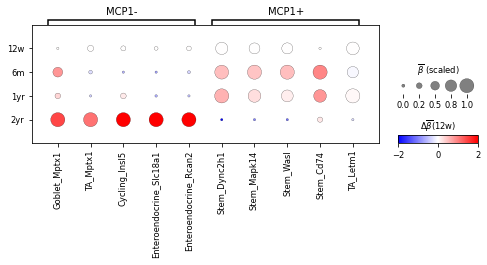

In [10]:
mroi = 'crypt mid'

mcp_genes = {
    'MCP1-': [('Goblet', 'Mptx1'),
              ('TA', 'Mptx1'),
              ('Cycling', 'Insl5'),
              ('Enteroendocrine', 'Slc18a1'),
              ('Enteroendocrine', 'Rcan2')],
    'MCP1+': [('Stem', 'Dync2h1'),
              ('Stem', 'Mapk14'),
              ('Stem', 'Wasl'),
              ('Stem', 'Cd74'),
              ('TA', 'Letm1')]
}
'''
mcp_genes = {
    'MCP1-': [('Stem', 'Dync2h1'), 
              ('Stem', 'Wasl'), 
              ('Stem', 'Cd74'), 
              ('Stem', 'Acot13'), 
              ('Stem', 'Chp1'), 
              ('Stem', 'Chrm3'), 
              ('TA', 'Letm1'), 
              ('Stem', 'Rasgrf2'), 
              ('Stem', 'Kcnk1'), 
              ('Stem', '1700040L02Rik'), 
              ('Stem', 'Supt3'), 
              ('Stem', 'Mapk14')],
    'MCP1+': [('Goblet', 'Mptx1'),
              ('TA', 'Mptx1'),
              ('Cycling', 'Timm8a1'),
              ('Cycling', 'Slc15a2'), 
              ('Stem', 'Armcx4'), 
              ('Tuft', 'St3gal1'), 
              ('Enteroendocrine', 'Ccdc68'), 
              ('Tuft', 'Msantd4'), 
              ('Stem', 'Ints6'), 
              ('Enteroendocrine', 'Cenpt'), 
              ('Cycling', 'Zfp182'), 
              ('Enteroendocrine', 'Slc18a1'), 
              ('Tuft', 'H2-Q10'), 
              ('Stem', 'Ttr'), 
              ('Tuft', 'Capn7'), 
              ('Enteroendocrine', 'Tfb1m'), 
              ('Cycling', 'Insl5'), 
              ('Enteroendocrine', 'Rcan2'), 
              ('Enteroendocrine', 'Cdca3'), 
              ('Enteroendocrine', 'Fam76a'), 
              ('Tuft', 'Foxq1'),
              ('Tuft', '2810474O19Rik'),
              ('Tuft', 'Pgap1'),
              ('Enteroendocrine', 'Lefty1'),
              ('Tuft', 'Rwdd2b'),
              ('Tuft', 'Itln1')]
}
'''

col_labels = dict([(k, ['_'.join(cg) for cg in mcp_genes[k]]) for k in mcp_genes.keys()])

for region in ['Proximal', 'Middle', 'Distal']:
    df_delta, df_mean_scaled = mean_betas_timecourse(mroi, 
                                                     region,
                                                     mcp_genes['MCP1-']+mcp_genes['MCP1+'],
                                                     t_limited)

    ax_dict = mcp_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(12w)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           col_groups=col_labels,
                           vmin=-2, vmax=2, cmap='bwr',
                          figsize=(8,3)
                         )
    
    plt.savefig(os.path.join(plot_dir, 'fig4_mcpgenes_%s_%s.svg' % (mroi.replace(' ', '-'), region)))

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorica

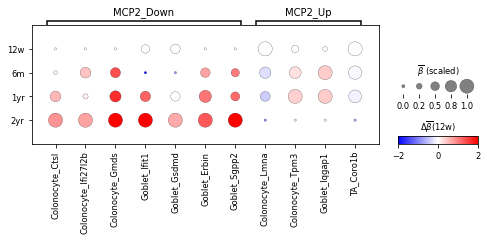

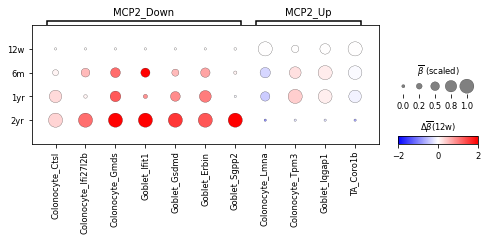

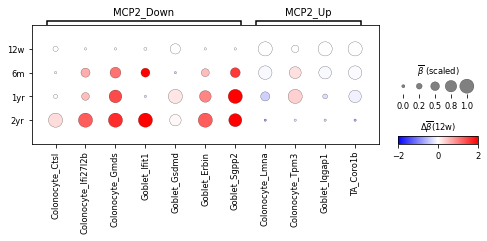

In [42]:
mroi = 'crypt apex'
mcp_genes = {
    'MCP2_Down': [('Colonocyte', 'Ctsl'),
                  ('Colonocyte', 'Ifi27l2b'),
                  ('Colonocyte', 'Gmds'),
                  ('Goblet', 'Ifit1'),
                  ('Goblet', 'Gsdmd'),
                  ('Goblet', 'Erbin'),
                  ('Goblet', 'Sgpp2')],
    'MCP2_Up': [('Colonocyte', 'Lmna'),
                ('Colonocyte', 'Tpm3'),
                ('Goblet', 'Iqgap1'),
                ('TA', 'Coro1b')]
}
col_labels = dict([(k, ['_'.join(cg) for cg in mcp_genes[k]]) for k in mcp_genes.keys()])

for region in ['Proximal', 'Middle', 'Distal']:
    df_delta, df_mean_scaled = mean_betas_timecourse(mroi, 
                                                     region,
                                                     mcp_genes['MCP2_Down']+mcp_genes['MCP2_Up'],
                                                     t_limited)

    ax_dict = mcp_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(12w)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           col_groups=col_labels,
                           vmin=-2, vmax=2, cmap='bwr')
    
    plt.savefig(os.path.join(plot_dir, 'fig4_mcpgenes_%s_%s.svg' % (mroi.replace(' ', '-'), region)))

/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Users/adaly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorica

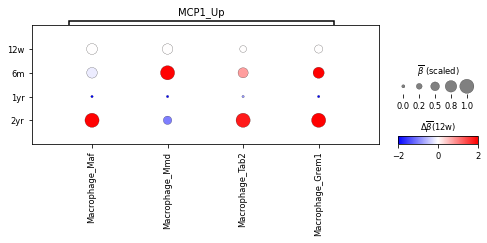

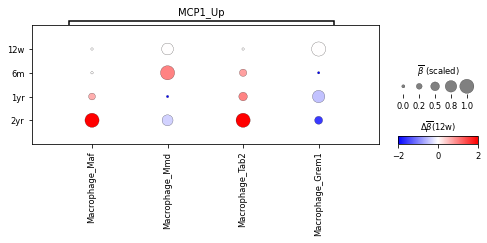

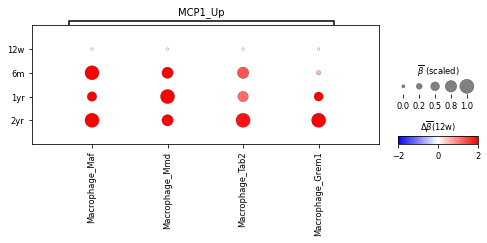

In [43]:
mroi = 'interna'
mcp_genes = {
    'MCP1_Up': [('Macrophage', 'Maf'),
                ('Macrophage', 'Mmd'),
                ('Macrophage', 'Tab2'),
                ('Macrophage', 'Grem1')]
}
col_labels = dict([(k, ['_'.join(cg) for cg in mcp_genes[k]]) for k in mcp_genes.keys()])

for region in ['Proximal', 'Middle', 'Distal']:
    df_delta, df_mean_scaled = mean_betas_timecourse(mroi, 
                                                     region,
                                                     mcp_genes['MCP1_Up'],
                                                     t_limited)

    ax_dict = mcp_dotplot(df_delta, df_mean_scaled, 
                           colorbar_title=r'$\Delta\overline{\beta}$(12w)',
                           size_title=r'$\overline{\beta}$ (scaled)',
                           col_groups=col_labels,
                           vmin=-2, vmax=2, cmap='bwr')
    
    plt.savefig(os.path.join(plot_dir, 'fig4_mcpgenes_%s_%s.svg' % (mroi.replace(' ', '-'), region)))